# Graph Classification

Build a GNN to predict whether a molecule inhibits HIV virus replication or not (i.e. a binary target) given its molecular structure as a graph.

We will use the [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset to train and evaluate our GNN.

## Setup

The following two cells import Pytorch and some supporting packages that depend on the version of Pytorch, as well as Pytorch Geometric (PyG) and the OGB package. 

We need [Open Graph Benchmark (OGB)](https://ogb.stanford.edu/docs/home/) package here for its `PygGraphPropPredDataset` dataset loader and the `AtomEncoder` (more on that below).


In [ ]:
import torch
torch.__version__

'1.9.0+cu111'

In [1]:
%%capture
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric
!pip install ogb

## Dataset

The [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset is part of the [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a) dataset. 

The dataset contains 41,127 molecules, each represented as a graph. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not. 

Use the `PygGraphPropPredDataset` loader to retrieve the `ogbg-molhiv` dataset. To see how this is done, refer to the Data Loaders section of the [OGB documentation](https://ogb.stanford.edu/docs/home/).

Once the dataset is downloaded, find and confirm the following details.

1. Number of features for each node (should be 9)
2. Number of targets (should be 2)
3. Number of graphs in dataset (should be 41127)

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset

In [ ]:
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
dataset

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 61937.18it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 23840.01it/s]


Saving...


Done!


PygGraphPropPredDataset(41127)

In [ ]:
dataset.num_features

9

In [ ]:
dataset.num_classes

2

In [ ]:
len(dataset)

41127

## Visualize Dataset

Pick a random graph from the dataset and visualize what it looks like. You can do it in at one of at least two ways.

* __Using the edge_index__ -- extract the `edge_index` from the `Data` object and reformat it as a list of node tuples. Create a networkx graph using `networkx.from_edgelist(edges)` then use `networkx.draw()` to draw the graph.
* __Using PyG utils__ -- PyG offers a `utils.to_networkx()` that takes a `Data` object directly. Use that to create a `networkx` graph object, then use `networkx.draw()` to draw the graph.

In [ ]:
import networkx as nx
import torch_geometric.utils as pyg_utils

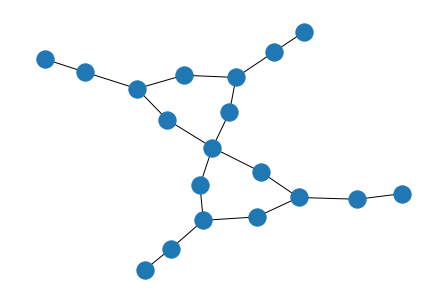

In [ ]:
def draw_graph(edge_index, gids=[]):
  src = edge_index[0].tolist()
  dst = edge_index[1].tolist()
  edges = [(s, d) for s, d in zip(src, dst)]
  G = nx.from_edgelist(edges)
  nx.draw(G)

draw_graph(dataset[0].edge_index)

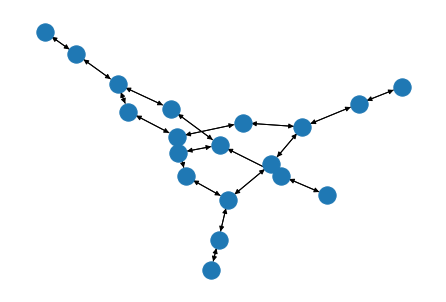

In [ ]:
G = pyg_utils.to_networkx(dataset[0])
nx.draw(G)

## Split and DataLoader

The dataset created using `PygGraphPropPredDataset` comes with a `get_idx_splits()` function that provides indices for train, validation and test splits.

Extract this information and use it to build the training, validation and test DataLoaders. Refer to the Data Loaders section of the [OGB Documentation](https://ogb.stanford.edu/docs/home/) page to see how to do this.

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
split_idx = dataset.get_idx_split()
split_idx

{'test': tensor([    0,     1,     2,  ..., 10122, 10124, 10125]),
 'train': tensor([    3,     4,     5,  ..., 41124, 41125, 41126]),
 'valid': tensor([10127, 10129, 10132,  ..., 22785, 22786, 22788])}

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=BATCH_SIZE)

## Model

The model we will use is very similar to our node classification model. 

As before, we have a variable number of `GCNConv` layers that determine how large a neighborhood we are considering for each node (k GCN layers == k-hop neighborhood).

However, in this case we are using the GCN layers as a graph encoder. Assuming that the output of the last GCN has dimension _H_ and the number of nodes in a graph is _N_, then the encoding for that graph after passing through the GCN layers is _(H, N)_.

Each graph can have variable number of nodes, so we then pass this data through a pooling layer that pools across all the nodes in the graph, giving us a vector of size _(H)_ for each graph.

A batch of these vectors are then fed into the classifier head, which is one or more Linear layers that project the vectors from the hidden dimension to the output dimension, i.e. the number of classes.

---

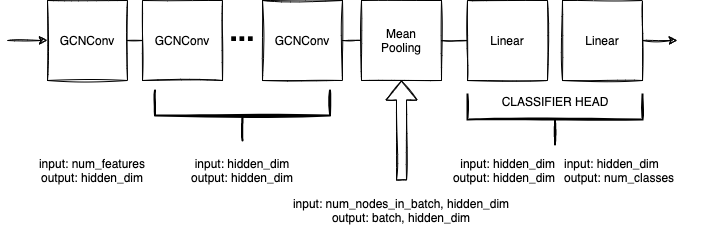

---
Build the GNN model for graph prediction with the following layers.

1. An `AtomEncoder` layer to convert from the 9 categorical features based on the chemical properties of each node (atom) in the molecule into a fixed size hidden representation _H_ (should be parameterized). Refer to the Module section of the [OGB Documentation](https://ogb.stanford.edu/docs/graphprop/) for more information.
2. _(k - 1)_ layers, where _k_ is the number of graph layers requested (should be parameterized).
  * `GCNConv` layer with input and output dimensions _H_.
  * A `torch.nn.BatchNorm1d` layer with _H_ features.
  * A `torch.nn.ReLU` activation layer
  * A `torch.nn.Dropout` layer (dropout percentage should be parameterized)
3. The _k-th_ layer is a `GCNConv` with input and output dimensions _H_.
3. A `torch_geometric.global_mean_pool` pooling layer that pools across the batch of node features.
4. A single `torch.nn.Linear` layer to project the batch of vectors with dimension _H_ to the target dimension (number of classes, should be parameterized).

Test the model using a batch of data from the train DataLoader and verify that the input and output are correct.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from ogb.graphproppred.mol_encoder import AtomEncoder

In [ ]:
class GraphClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim

    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_mean_pool(x, data.batch)
    x = self.clf_head(x)
    return x
    # return F.log_softmax(x, dim=1)


In [ ]:
model = GraphClassifier(dataset.num_features, 100, 
                        dataset.num_classes, 3, 0.5)
for batch in train_loader:
  print(batch)
  pred = model(batch)
  break
  
pred.size()

DataBatch(edge_index=[2, 1868], edge_attr=[1868, 3], x=[870, 9], y=[32, 1], batch=[870], ptr=[33])


torch.Size([32, 2])

## Training Loop

As with our node classification example, the training loop is composed of alternate calls to `train_step` and `eval_step` functions over multiple epochs of training.

1. Build the `train_step` function with the following signature. You can copy-paste most of what you built in the previous exercise except for some important differences.
    * the size of the batch is given by `batch.num_graphs` and not just `len(batch)`
    * we are using a different loss function `CrossEntropyLoss` instead of `NLLLoss`, that might require changes to how you compute the loss.

```
def train_step(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               loss_fn, torch.nn.CrossEntropyLoss,
               train_loader: torch_geometric.loader.DataLoader,
               device: torch.Device
              ) -> (
               train_loss: Float, 
               train_acc: Float
              )
```

2. Build the `eval_step` function with the signature given below. As before, the same code should be usable for validation and testing by appropriately setting the `is_validation` parameter. Also you may be able to copy-paste the code from the previous exercise here as well, with the same caveats listed in the instructions for the `train_step`.

```
def eval_step(model: torch.nn.Module, 
              loss_fn: torch.nn.CrossEntropyLoss, 
              eval_loader: torch_geometric.loader.DataLoader,
              device: torch.Device, 
              is_validation=False: boolean
            ) -> (
              eval_loss: Float,
              eval_acc: Float
            )
```

3. Build the `train_loop` function with the following signature. You should be able to copy-paste this directly from the node classification exercise. It takes in a union of parameters required by the `train_step` and `eval_step` and produces a `history` list of the tuple `(train_loss, train_acc, val_loss, val_acc)` for drawing the loss plots. It periodically (`log_every`) writes out the values to console.

```
def train_loop(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               loss_fn: torch.nn.CrossEntropyLoss, 
               train_loader: torch_geometric.loader.DataLoader,
               val_loader: torch_geometric.loader.DataLoader,
               device: torch.Device, 
               num_epochs: Int, 
               log_every=5: Int
              ) -> List[(Float, Float, Float, Float)
```

In [ ]:
def train_step(model, optimizer, loss_fn, train_loader, device):
  model.train()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in train_loader:
    batch = batch.to(device)
    optimizer.zero_grad()
    pred = model(batch)
    label = batch.y.squeeze(dim=-1)
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    # update values for reporting
    total_loss += loss.item()
    total_correct += pred.argmax(dim=-1).eq(label).sum().item()
    total_rows += batch.num_graphs
  return total_loss / total_rows, total_correct / total_rows


def eval_step(model, loss_fn, eval_loader, device, is_validation=False):
  model.eval()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in eval_loader:
    batch = batch.to(device)
    with torch.no_grad():
      pred = model(batch)
      label = batch.y.squeeze(dim=-1)
      loss = loss_fn(pred, label)
      total_loss += loss.item()
      total_correct += pred.argmax(dim=-1).eq(label).sum().item()
      total_rows += batch.num_graphs
  return total_loss / total_rows, total_correct / total_rows


def train_loop(model, optimizer, loss_fn, train_loader, val_loader, device, 
               num_epochs, log_every=5):
  history = []
  for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, optimizer, loss_fn, 
                                       train_loader, device)
    val_loss, val_acc = eval_step(model, loss_fn, val_loader, 
                                  device, is_validation=True)
    history.append((train_loss, train_acc, val_loss, val_acc))
    if epoch == 0 or (epoch + 1) % log_every == 0:
      print("EPOCH {:3d}, TRAIN loss: {:.5f}, acc: {:.5f}, VAL loss: {:.5f}, acc: {:.5f}"
        .format(epoch + 1, train_loss, train_acc, val_loss, val_acc))
  return history


## Training

Now train the network using the hyperparameters in the cell below.

1. At this point, if your code runs without errors, you can switch from using CPU to GPU. To do so, go to Runtime :: Change Runtime Type and setting Hardware Accelerator to GPU. You will need to rerun the notebook from the beginning once you switch from CPU to GPU.
2. Set the device to `torch.device("cuda")` if GPU is available otherwise set it to `torch.device("cpu")`.
3. Instantiate the GNN model and set the model to the appropriate device using `model.to(device)`.
4. Define the loss function to be `torch.nn.CrossEntropyLoss`.
5. Instantiate the `torch.optim.Adam` optimizer with model parameters and the appropriate `LEARNING_RATE` parameters.
6. Run the training loop for `NUM_EPOCHS` epochs and capture the training and validation losses and accuracies returned.
7. Use the training and validation losses and accuracies tuple to plot the loss and accuracy curves for the model training (the plotting code should be identical to the one you built in the previous Node Classification exercise).

In [ ]:
# model parameters
INPUT_DIM = dataset.num_features
HIDDEN_DIM = 256
OUTPUT_DIM = dataset.num_classes
NUM_GCN_LAYERS = 5
DROPOUT_PCT = 0.5

# optimizer
LEARNING_RATE = 1e-3

NUM_EPOCHS = 30

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = GraphClassifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model = model.to(device)

In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
history = train_loop(model, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00498, acc: 0.96186, VAL loss: 0.00299, acc: 0.98031
EPOCH   5, TRAIN loss: 0.00440, acc: 0.96228, VAL loss: 0.00273, acc: 0.98104
EPOCH  10, TRAIN loss: 0.00423, acc: 0.96252, VAL loss: 0.00257, acc: 0.98031
EPOCH  15, TRAIN loss: 0.00410, acc: 0.96356, VAL loss: 0.00252, acc: 0.98128
EPOCH  20, TRAIN loss: 0.00406, acc: 0.96331, VAL loss: 0.00310, acc: 0.98006
EPOCH  25, TRAIN loss: 0.00396, acc: 0.96465, VAL loss: 0.00261, acc: 0.98055
EPOCH  30, TRAIN loss: 0.00391, acc: 0.96511, VAL loss: 0.00252, acc: 0.98104


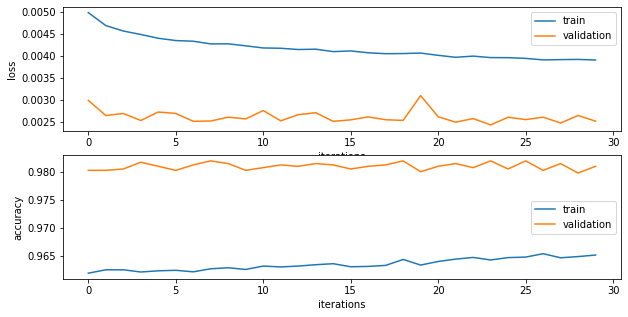

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_training_plots(history):
  train_losses, train_accs, val_losses, val_accs = [], [], [], []
  for train_loss, train_acc, val_loss, val_acc in history:
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  xs = np.arange(len(train_losses))

  plt.figure(figsize=(10, 5))

  plt.subplot(2, 1, 1)
  plt.plot(xs, train_losses, label="train")
  plt.plot(xs, val_losses, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(xs, train_accs, label="train")
  plt.plot(xs, val_accs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  _ = plt.show()


display_training_plots(history)

## Evaluation

Now evaluate your trained model on the held out test set. You can reuse the `eval_step()` function that you used for evaluating the model with the validation set during the training.

Report the accuracy value on the test set to 5 decimal places.

In [ ]:
_, test_acc = eval_step(model, loss_fn, test_loader, device)
print("Test accuracy: {:.5f}".format(test_acc))

Test accuracy: 0.96596


## Repeat Classification with MAX Pooling

Investigate the effect on the graph classification accuracy by changing the global pooling strategy to MAX, i.e. `torch_geometric.nn.global_max_pool`. Here are the steps.

1. Either copy-paste the previous network and make the necessary changes, or parameterize your original model with a `pooling_strategy` parameter.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `CrossEntropyLoss` loss function
4. Instantiate the `Adam` optimizer with the new model parameters.
5. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
6. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
7. Compute and report the accuracy of the network with MAX pooling against the held-out test set.

In [ ]:
class GraphClassifier_MAX(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier_MAX, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim
    
    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_max_pool(x, data.batch)
    x = self.clf_head(x)
    return x


In [ ]:
model_MAX = GraphClassifier_MAX(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model_MAX = model_MAX.to(device)

In [ ]:
optimizer = optim.Adam(model_MAX.parameters(), lr=LEARNING_RATE)
history_MAX = train_loop(model_MAX, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00492, acc: 0.96252, VAL loss: 0.00279, acc: 0.98031
EPOCH   5, TRAIN loss: 0.00435, acc: 0.96368, VAL loss: 0.00266, acc: 0.98177
EPOCH  10, TRAIN loss: 0.00408, acc: 0.96453, VAL loss: 0.00258, acc: 0.98055
EPOCH  15, TRAIN loss: 0.00393, acc: 0.96590, VAL loss: 0.00246, acc: 0.98055
EPOCH  20, TRAIN loss: 0.00379, acc: 0.96696, VAL loss: 0.00253, acc: 0.98152
EPOCH  25, TRAIN loss: 0.00373, acc: 0.96736, VAL loss: 0.00267, acc: 0.98079
EPOCH  30, TRAIN loss: 0.00365, acc: 0.96730, VAL loss: 0.00242, acc: 0.98322


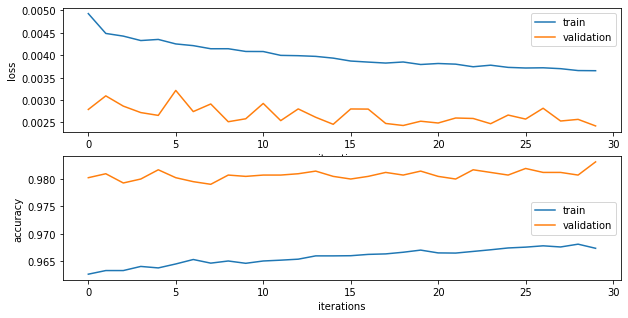

In [ ]:
display_training_plots(history_MAX)

In [ ]:
_, test_acc = eval_step(model_MAX, loss_fn, test_loader, device)
print("Test accuracy: {:.5f}".format(test_acc))

Test accuracy: 0.97058


## Repeat Classification with SUM Pooling

Now investigate the effect on the graph classification accuracy by changing the global pooling strategy to SUM, i.e., `torch_geometric.nn.global_add_pool`. Here are the steps.

1. Either copy-paste the previous network and make the necessary changes, or parameterize your original model with a `pooling_strategy` parameter.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `CrossEntropyLoss` loss function
4. Instantiate the `Adam` optimizer with the new model parameters.
5. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
6. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
7. Compute and report the accuracy of the network with SUM pooling against the held-out test set.

In [ ]:
class GraphClassifier_SUM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, 
               num_graph_layers, dropout_pct):

    super(GraphClassifier_SUM, self).__init__()
    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct
    self.output_dim = output_dim
    
    # convert manually crafted categorical features to continuous
    self.encoder = AtomEncoder(hidden_dim)

    self.convs = nn.ModuleList()
    for i in range(num_graph_layers):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers - 1):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.clf_head = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.encoder(x)
    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    x = self.convs[-1](x, edge_index)

    x = pyg_nn.global_add_pool(x, data.batch)
    x = self.clf_head(x)
    return x


In [ ]:
model_SUM = GraphClassifier_SUM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
model_SUM = model_SUM.to(device)

In [ ]:
optimizer = optim.Adam(model_SUM.parameters(), lr=LEARNING_RATE)
history_SUM = train_loop(model_SUM, optimizer, loss_fn, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.00976, acc: 0.94988, VAL loss: 0.00405, acc: 0.98177
EPOCH   5, TRAIN loss: 0.00497, acc: 0.96295, VAL loss: 0.00302, acc: 0.98104
EPOCH  10, TRAIN loss: 0.00459, acc: 0.96301, VAL loss: 0.00305, acc: 0.97933
EPOCH  15, TRAIN loss: 0.00425, acc: 0.96404, VAL loss: 0.00286, acc: 0.97933
EPOCH  20, TRAIN loss: 0.00404, acc: 0.96468, VAL loss: 0.00237, acc: 0.98249
EPOCH  25, TRAIN loss: 0.00397, acc: 0.96526, VAL loss: 0.00261, acc: 0.98031
EPOCH  30, TRAIN loss: 0.00387, acc: 0.96638, VAL loss: 0.00247, acc: 0.97982


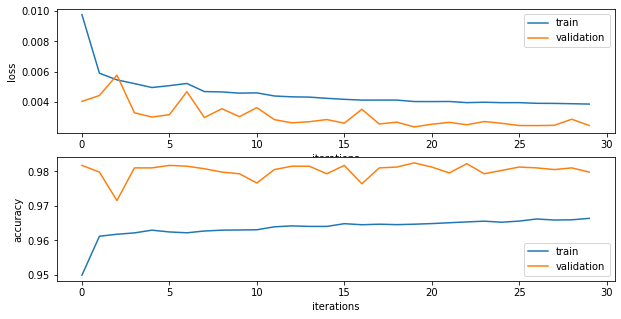

In [ ]:
display_training_plots(history_SUM)

In [ ]:
_, test_acc = eval_step(model_SUM, loss_fn, test_loader, device)
print("Test accuracy: {:.5f}".format(test_acc))

Test accuracy: 0.96791
